Can this be done?

In [1]:
from sgp4.api import Satrec, WGS72
from sgp4.conveniences import jday_datetime
from datetime import timezone
import datetime
import numpy as np
import pandas as pd

from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def __jday_convert(x):
    '''
    Algorithm from python-sgp4:

    from sgp4.functions import jday
    jday(x.year, x.month, x.day, x.hour, x.minute, x.second + x.microsecond * 1e-6)
    '''
    jd = (367.0 * x.year
         - 7 * (x.year + ((x.month + 9) // 12.0)) * 0.25 // 1.0
           + 275 * x.month / 9.0 // 1.0
           + x.day
         + 1721013.5)
    fr = (x.second + (x.microsecond * 1e-6) + x.minute * 60.0 + x.hour * 3600.0) / 86400.0;
    return jd, fr

In [3]:
sample_df = pd.read_pickle("./sample.pkl")
sample_df["EPOCH"] = pd.to_datetime(sample_df.EPOCH)

In [4]:
sample_df.columns

Index(['CCSDS_OMM_VERS', 'COMMENT', 'CREATION_DATE', 'ORIGINATOR',
       'OBJECT_NAME', 'OBJECT_ID', 'CENTER_NAME', 'REF_FRAME', 'TIME_SYSTEM',
       'MEAN_ELEMENT_THEORY', 'EPOCH', 'MEAN_MOTION', 'ECCENTRICITY',
       'INCLINATION', 'RA_OF_ASC_NODE', 'ARG_OF_PERICENTER', 'MEAN_ANOMALY',
       'EPHEMERIS_TYPE', 'CLASSIFICATION_TYPE', 'NORAD_CAT_ID',
       'ELEMENT_SET_NO', 'REV_AT_EPOCH', 'BSTAR', 'MEAN_MOTION_DOT',
       'MEAN_MOTION_DDOT', 'SEMIMAJOR_AXIS', 'PERIOD', 'APOAPSIS', 'PERIAPSIS',
       'OBJECT_TYPE', 'RCS_SIZE', 'COUNTRY_CODE', 'LAUNCH_DATE', 'SITE',
       'DECAY_DATE', 'FILE', 'GP_ID', 'TLE_LINE0', 'TLE_LINE1', 'TLE_LINE2'],
      dtype='object')

<IPython.core.display.Javascript object>


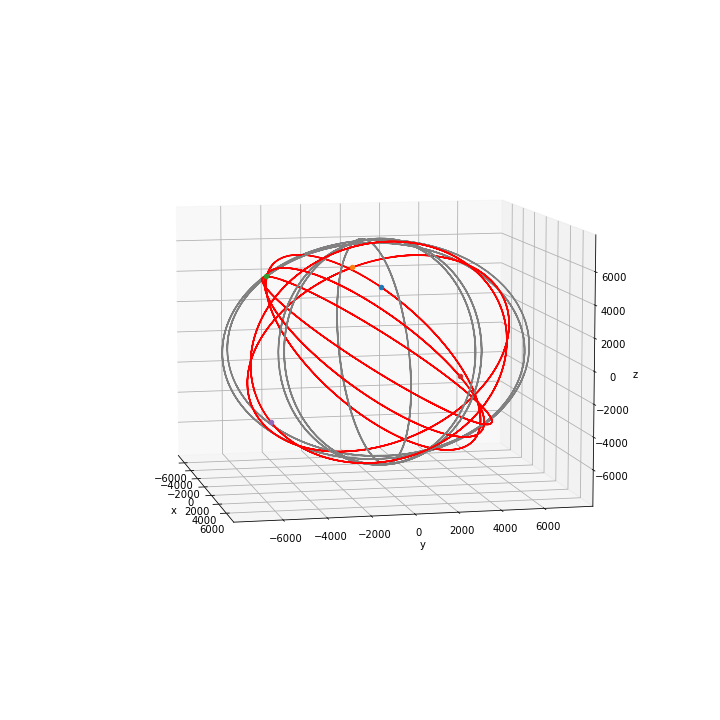

In [8]:
%matplotlib notebook
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

for _,row in sample_df.sample(5).iterrows():
    epoch_jd, epoch_fr = __jday_convert(row.EPOCH)
    jds = []
    frs = []
    for i in np.arange(0.0,0.2,0.001):
        jds.append(epoch_jd)
        frs.append(epoch_fr+i)

    e,r,v = Satrec.twoline2rv(row.TLE_LINE1, row.TLE_LINE2).sgp4_array(jds, frs)
    df = pd.DataFrame(r,columns=["X","Y","Z"])
    df['D'] = df.X**2 + df.Y**2 + df.Z**2
    df['X2'] = df.X
    df['Y2'] = df.Y*np.cos(row.INCLINATION) - df.Z*np.sin(row.INCLINATION)
    df['Z2'] = df.Y*np.sin(row.INCLINATION) + df.Z*np.cos(row.INCLINATION)
    df['D2'] = df.X2**2 + df.Y2**2 + df.Z2**2
    df['X3'] = df.X2*np.cos(row.MEAN_ANOMALY) - df.Z2*np.sin(row.MEAN_ANOMALY)
    df['Y3'] = df.Y2
    df['Z3'] = df.X2*np.sin(row.MEAN_ANOMALY) + df.Z2*np.cos(row.MEAN_ANOMALY)
    df['D3'] = df.X3**2 + df.Y3**2 + df.Z3**2
    df['X4'] = df.X3*np.cos(row.RA_OF_ASC_NODE) - df.Y3*np.sin(row.RA_OF_ASC_NODE)
    df['Y4'] = df.X3*np.sin(row.RA_OF_ASC_NODE) + df.Y3*np.cos(row.RA_OF_ASC_NODE)
    df['Z4'] = df.Z3
    df['D4'] = df.X4**2 + df.Y4**2 + df.Z4**2
    
    

    ax.plot3D(df.X, df.Y, df.Z, 'gray')
#     ax.scatter(df.X[0], df.Y[0], df.Z[0])
#     ax.plot3D(df.X2, df.Y2, df.Z2, 'blue')
#     ax.scatter(df.X2[0], df.Y2[0], df.Z2[0])
#     ax.plot3D(df.X3, df.Y3, df.Z3, 'red')
#     ax.scatter(df.X3[0], df.Y3[0], df.Z3[0])
    ax.plot3D(df.X4, df.Y4, df.Z4, 'red')
    ax.scatter(df.X4[0], df.Y4[0], df.Z4[0])
    

    # x' = x*cos q - y*sin q
    # y' = x*sin q + y*cos q